# Using GloVe for text classification

In this pre-filled notebook, we use GloVe embeddings to train a classifier for sentiment analysis. For every review in the IMDB dataset we:
1. Tokenize the review into tokens.
2. Get the pre-trained GloVe vector for every token in the review (if they are in the voabulary of GloVe).
3. Average the vectors over the full review.
4. Send the vector through a logistic regression.

This time, we will batch the inputs instead of updating the weights once per epoch.

Before starting, to make your experiments reproducible, make sure to [force the random seed](https://pytorch.org/docs/stable/notes/randomness.html).

In [31]:
from copy import deepcopy
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

SEED = 42

## Using GloVe (1 point)

Let's get familier with GloVe embeddings. We download a small version of GloVe trained of 6 billion words, and use vectors of size 300.

The [torchtext documentation](https://pytorch.org/text/stable/vocab.html#glove) being quite poor, you can find details on the different pre-trained vectors on the [Stanford page](https://nlp.stanford.edu/projects/glove/).

In [14]:
glove = GloVe(name="6B", dim=300)
len(glove.stoi)

400000

In [15]:
glove.stoi["cat"], glove.itos[5450], glove.vectors[glove.stoi["cat"]].shape

(5450, 'cat', torch.Size([300]))

In [16]:
glove.itos[:5]

['the', ',', '.', 'of', 'to']

Notice that punctuations are part of GloVe's vocabulary.

To compare two words, we can look at their cosine similarity.

In [18]:
words = ["cat", "cats", "dog", "fridge"]
for word in words[1:]:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[words[0]]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()  # .item() is used to turn a tensor of a single value to a float
    print(f"{words[0]} x {word} = {similarity}")

cat x cats = 0.6815836429595947
cat x dog = 0.6816746592521667
cat x fridge = 0.09630905091762543


**\[1 point\] Find the closest word to "cat" in the whole vocabulary.**

In [180]:
word = "cat"
# Find the closest word to "cat" in the whole vocabulary (excluding "cat" itself)
# your code
top = torch.topk(  # we use torch.topk to find the top k values (in our case k=2, because we want to exclude the word itself)
        torch.cosine_similarity(
            glove.vectors[glove.stoi[word]].reshape(1, -1),
            glove.vectors,
            dim=1,
        ),
        k=2,
    )
closest_word = glove.itos[top[1][1]] # we take the second element of the topk result, because the first one is the word itself
similarity = top[0][1]
print(f"{word} x {closest_word} = {similarity}")

cat x dog = 0.6816746592521667


*dog* is the closest word to *cat*, with a cosine similarity of $0.6816746592521667$

## Dataset and split

As we keep the test set for final evaluation, we need to split the training set into a training and validation set. We make sure the split is **stratified** by class (same proportion of class in each split).

In [41]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=SEED
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]


Found cached dataset imdb (/Users/quentinfisch/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /Users/quentinfisch/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /Users/quentinfisch/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))


In [84]:
print((train_df.shape, valid_df.shape, test_df.shape))

((20000, 2), (5000, 2), (25000, 2))


## Prepare the inputs

### Text processing pipeline (2 points)

For a given entry, we want to
1. Tokenize the text.
2. Get the vectors for each token.
3. Average them.

For tokenization, let's use the "basic_english" tokenizer from torchtext.

In [33]:
tokenizer = get_tokenizer("basic_english", language="en")

**\[2 points\] Fill the `preprocess_text` function so it returns the mean of the GloVe vectors of all the tokens within a review.**

The two following functions can help.
* [torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html)
* [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html)

In [47]:
def vectorize_text(
    text: str, vocabulary: vocab.Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Turn a string into the average of the vectors of its tokens.
    Args:
        text: the input text.
        vocabulary: a pre-trained Vocab object.
        tokenizer: a tokenizer taking a text as input and returning a list of tokens.
    Returns:
        The average tensor over the tokens of the whole text.
    """
    # your code
    tokens = tokenizer(text)
    vectors = torch.stack([vocabulary[token] for token in tokens])
    return torch.mean(vectors, dim=0)

In [48]:
text_pipeline = partial(vectorize_text, vocabulary=glove, tokenizer=tokenizer)
assert text_pipeline("some text.").shape == torch.Size([300])

Now we turn our 3 sets into vectors and labels.

Our data are quite small, so we can keep everything in RAM.

In [49]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

### Batch processing (1 point)

Instead of doing one update per epoch, we feed the model batches of texts between each update. To do so, we use a simple data generator.

**\[1 point\] Fill the generator function.**


In [59]:
def data_generator(
    X: List[torch.tensor], y: List[int], batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    # Your code
    # yield the the returning values
    for i in range(0, len(X), batch_size):
        yield torch.stack(X[i:i + batch_size]), torch.tensor(y[i:i + batch_size])

In [60]:
train_gen = lambda: data_generator(X_train, y_train, batch_size=32)
for X, y in train_gen():
    assert X.shape == torch.Size([32, 300])
    assert y.shape == torch.Size([32])
    break

## The classifier (1 point)

We create a very simple classifier corresponding a logistic regression.

**\[1 point\] Fill the classifier's code. The forward function needs to return a logit and not the output of a sigmoid.**

In [108]:
class SimpleClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
            nb_classes: the output dimension.
        """
        # your code
        super().__init__()
        self.linear = nn.Linear(embedding_size, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        # your code
        return self.linear(x)  # return the logits

## Training (3 points)

We put everything above together and train the classifier.

In [62]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [63]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

**\[3 points\] Fill the following cells. Make sure you save the best model evaluated on the validation set.**
* The `deepcopy` function might help.

In [162]:
model = SimpleClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters())

In [163]:
nb_epochs = 50
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf

for epoch in tqdm(range(nb_epochs)):

    # training
    model.train()
    # training loop (your code)
    train_loss = length = 0
    for X, y in train_gen():
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        output = torch.sigmoid(output)
        loss = criterion(output, y.float().unsqueeze(1))
        loss.backward() # compute all gradients with backpropagation
        optimizer.step() # update the parameters
        train_loss += loss.item()
        length += 1
    train_losses.append(train_loss / length)
    
    # validation
    model.eval()
    # validation loop (your code)
    valid_loss = length = 0
    with torch.no_grad():  # we don't need to compute the gradients
        for X, y in valid_gen():
            X, y = X.to(device), y.to(device)
            output = model(X)
            output = torch.sigmoid(output)
            loss = criterion(output, y.float().unsqueeze(1))
            valid_loss += loss.item()
            length += 1
    valid_losses.append(valid_loss / length)

    # save the best model
    if valid_loss < best_validation_loss:
        best_validation_loss = valid_loss
        best_model = deepcopy(model)

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch + 1}/{nb_epochs}, "
            f"Train Loss: {train_losses[-1]:.4f}, "
            f"Valid Loss: {valid_losses[-1]:.4f}"
        )

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.6936, Valid Loss: 0.6871
Epoch 11/50, Train Loss: 0.6324, Valid Loss: 0.6332
Epoch 21/50, Train Loss: 0.6157, Valid Loss: 0.6180
Epoch 31/50, Train Loss: 0.6076, Valid Loss: 0.6107
Epoch 41/50, Train Loss: 0.6026, Valid Loss: 0.6061


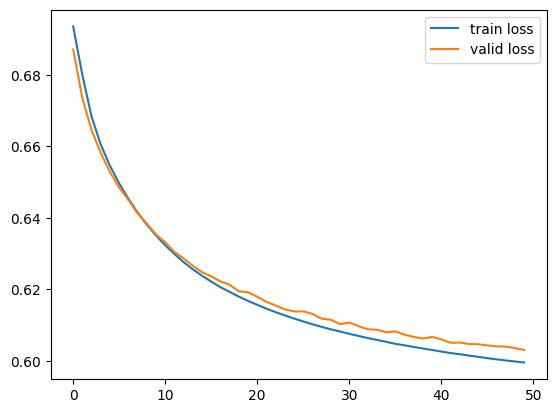

In [164]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

The train and validation losses are close to each other, which means we are not overfitting

## Evaluation (3 point)

**\[1 point\] Compute the accuracy for the 3 splits (training, validation, test).**

In [181]:
# Your code

def accuracy(model: nn.Module, data_gen: Callable[[], torch.Tensor]) -> float:
    """
    Compute the accuracy of the model on the given data.
    
    Parameters
    ----------
    model: nn.Module
        The model to evaluate.
    data_gen: Callable[[], torch.Tensor]
        A function that returns a generator of batches.

    Returns
    -------
    float
        The accuracy of the model on the given data.
    """
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X, y in data_gen():
            X, y = X.to(device), y.to(device)
            output = model(X)
            output = torch.sigmoid(output)
            pred = output.round()
            correct += (pred == y.float().unsqueeze(1)).sum().item()
            total += len(y)
    return correct / total

print(f"Train accuracy: {accuracy(best_model, train_gen):.4f}")
print(f"Valid accuracy: {accuracy(best_model, valid_gen):.4f}")
print(f"Test accuracy: {accuracy(best_model, test_gen):.4f}")

Train accuracy: 0.8050
Valid accuracy: 0.8014
Test accuracy: 0.7970


We get the following accuracies:
- Train accuracy: 0.8050
- Valid accuracy: 0.8014
- Test accuracy: 0.7970

The accuracies are similar, which means we are not overfitting. Also, the accuracy is higher (~80%) than the previous lab using features extracted from the text.

**\[1 point\] For two wrongly classified samples, try guessing why the model was wrong.**

In [182]:
# For two wrongly classified samples, try guessing why the model was wrong

wrong = []

for i, X in enumerate(X_test):
    y = y_test[i]
    output = best_model(X)
    output = torch.sigmoid(output)
    pred = output.round()
    if pred.item() != y:
        wrong.append((pred.item(), y, i)) # (prediction, actual, index)
    if len(wrong) >= 2: # we only need two exemples
        break

for (pred, y, index) in wrong[:2]:
    print(f"Predicted: {pred}, Actual: {y}")
    print(f"Text: {test_df['text'][index]}")

Predicted: 1.0, Actual: 0
Text: Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can tell Isaac has a real passion for the genre and his films are always eventful, creative and sharp affairs, with some of the best fight sequences an action fan could hope for. In particular he has found a muse with Scott Adkins, as talented an actor and action performer as you could hope for. This is borne out with Special Forces and Undisputed 2, but unfortunately The Shepherd just doesn't live up to their abilities.<br /><br />There is no doubt that JCVD looks better here fight-wise than he has done in years, especially in the fight he has (for pretty much no reason) in a prison cell, and in the final showdown with Scott, but look in his eyes. JCVD seems to be dead inside. There's nothing in his eyes at all. It's like he just doesn't care about anything throu

Two wrongly classified samples:

1. *Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can tell Isaac has a real passion for the genre and his films are always eventful, creative and sharp affairs, with some of the best fight sequences an action fan could hope for. In particular he has found a muse with Scott Adkins, as talented an actor and action performer as you could hope for. This is borne out with Special Forces and Undisputed 2, but unfortunately The Shepherd just doesn't live up to their abilities.<br /><br />There is no doubt that JCVD looks better here fight-wise than he has done in years, especially in the fight he has (for pretty much no reason) in a prison cell, and in the final showdown with Scott, but look in his eyes. JCVD seems to be dead inside. There's nothing in his eyes at all. It's like he just doesn't care about anything throughout the whole film. And this is the leading man.<br /><br />There are other dodgy aspects to the film, script-wise and visually, but the main problem is that you are utterly unable to empathise with the hero of the film. A genuine shame as I know we all wanted this film to be as special as it genuinely could have been. There are some good bits, mostly the action scenes themselves. This film had a terrific director and action choreographer, and an awesome opponent for JCVD to face down. This could have been the one to bring the veteran action star back up to scratch in the balls-out action movie stakes.<br /><br />Sincerely a shame that this didn't happen.*

2. *Four things intrigued me as to this film - firstly, it stars Carly Pope (of "Popular" fame), who is always a pleasure to watch. Secdonly, it features brilliant New Zealand actress Rena Owen. Thirdly, it is filmed in association with the New Zealand Film Commission. Fourthly, a friend recommended it to me. However, I was utterly disappointed. The whole storyline is absurd and complicated, with very little resolution. Pope's acting is fine, but Owen is unfortunately under-used. The other actors and actresses are all okay, but I am unfamiliar with them all. Aside from the nice riddles which are littered throughout the movie (and Pope and Owen), this film isn't very good. So the moral of the story is...don't watch it unless you really want to.*

These two samples are wrongly classified as positive. The first one is a negative review, but the model is fooled by the fact that the reviewer is praising the director and the action choreographer. The second one is a negative review, but the model is fooled by the fact that the reviewer saying good things about the actors and actresses.

**\[1 point\] Code a `predict` function which take some text as input and returns a prediction class and score (the output of the sigmoid).**

In [167]:
def predict(
    text: str,
    text_pipeline: Callable[[str], torch.Tensor],
    model: nn.Module,
    device: str,
) -> Tuple[int, float]:
    """
    Return the predicted class and score for a given input.
    Args:
        text: a given review.
        text_pipeline: a function taking a text as input and returning a tensor (model's input).
        model: a pre-trained model.
        device: the device on which the computation occurs.
    Returns:
        A tuple (label, score).
    """
    # Your code
    X = text_pipeline(text)
    X = X.to(device)
    output = model(X)
    output = torch.sigmoid(output)
    pred = output.round()
    return int(pred.item()), float(output.item())

In [168]:
text = "In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle."
predict(text, text_pipeline, model, device)

(0, 0.22153450548648834)

On the example *In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle.*, the predicted output is (0, 0.22153450548648834), so it is classified as negative. However, this text is neutral, and even a human can't really tell if it is positive or negative.

## Bonus

Modify the classifier. Instead of using a simple logistic regression, create a multilayer perceptron. Something like `input -> linear(embedding_size, 128) -> activation function -> linear(128, nb_classes) -> output`, for a two layer perceptron.

For the activation function, you can use [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) or [another non-linear activation function](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) of your choice.

Train your new classifier, look at the loss, and compare its accuracy with the logistic regression. Keep the model with the best validation loss.

In [171]:
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    """
    A simple MLP classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
            nb_classes: the output dimension.
        """
        super().__init__()
        self.linear1 = nn.Linear(embedding_size, 128)
        self.linear2 = nn.Linear(128, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [173]:
model_mlpc = MLPClassifier(300, 1)
criterion_mlpc = nn.BCEWithLogitsLoss()
optimizer_mlpc = torch.optim.Adam(model_mlpc.parameters())

Let's use the same training loop as before, but with a different classifier.

In [174]:
nb_epochs_mlpc = 50
train_losses_mlpc, valid_losses_mlpc = [], []

best_model_mlpc = model_mlpc
best_validation_loss_mlpc = np.Inf

for epoch in tqdm(range(nb_epochs_mlpc)):

    # training
    model_mlpc.train()
    # training loop (your code)
    train_loss = length = 0
    for X, y in train_gen():
        X, y = X.to(device), y.to(device)
        optimizer_mlpc.zero_grad()
        output = model_mlpc(X)
        output = torch.sigmoid(output)
        loss = criterion_mlpc(output, y.float().unsqueeze(1))
        loss.backward()
        optimizer_mlpc.step()
        train_loss += loss.item()
        length += 1
    train_losses_mlpc.append(train_loss / length)
    
    # validation
    model_mlpc.eval()
    # validation loop (your code)
    valid_loss = length = 0
    with torch.no_grad():
        for X, y in valid_gen():
            X, y = X.to(device), y.to(device)
            output = model_mlpc(X)
            output = torch.sigmoid(output)
            loss = criterion_mlpc(output, y.float().unsqueeze(1))
            valid_loss += loss.item()
            length += 1
    valid_losses_mlpc.append(valid_loss / length)

    # save the best model
    if valid_loss < best_validation_loss_mlpc:
        best_validation_loss_mlpc = valid_loss
        best_model_mlpc = deepcopy(model_mlpc)

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch + 1}/{nb_epochs_mlpc}, "
            f"Train Loss: {train_losses_mlpc[-1]:.4f}, "
            f"Valid Loss: {valid_losses_mlpc[-1]:.4f}"
        )

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.6574, Valid Loss: 0.6215
Epoch 11/50, Train Loss: 0.5803, Valid Loss: 0.5897
Epoch 21/50, Train Loss: 0.5774, Valid Loss: 0.5831
Epoch 31/50, Train Loss: 0.5760, Valid Loss: 0.5819
Epoch 41/50, Train Loss: 0.5766, Valid Loss: 0.5837


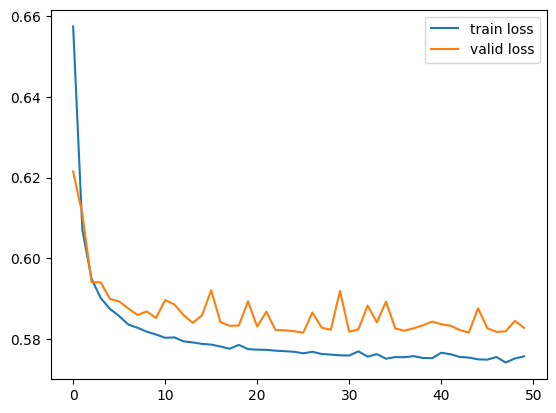

In [175]:
plt.plot(train_losses_mlpc, label="train loss")
plt.plot(valid_losses_mlpc, label="valid loss")
plt.legend()

In [176]:
print(f"Train accuracy: {accuracy(best_model_mlpc, train_gen):.4f}")
print(f"Valid accuracy: {accuracy(best_model_mlpc, valid_gen):.4f}")
print(f"Test accuracy: {accuracy(best_model_mlpc, test_gen):.4f}")

Train accuracy: 0.8451
Valid accuracy: 0.8276
Test accuracy: 0.8240


We get the following accuracy for the MLPC model

- Train accuracy: 0.8488

- Valid accuracy: 0.8306
    
- Test accuracy: 0.8254

In [179]:
text = "In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle."
predict(text, text_pipeline, model_mlpc, device)

(0, 1.547827976899896e-09)

In [178]:
# compare the two models (mlpc vs logistic regression)

print(f"Train accuracy: {accuracy(best_model_mlpc, train_gen):.4f}")
print(f"Valid accuracy: {accuracy(best_model_mlpc, valid_gen):.4f}")
print(f"Test accuracy: {accuracy(best_model_mlpc, test_gen):.4f}")

print(f"Train accuracy: {accuracy(best_model, train_gen):.4f}")
print(f"Valid accuracy: {accuracy(best_model, valid_gen):.4f}")
print(f"Test accuracy: {accuracy(best_model, test_gen):.4f}")

Train accuracy: 0.8451
Valid accuracy: 0.8276
Test accuracy: 0.8240
Train accuracy: 0.8050
Valid accuracy: 0.8014
Test accuracy: 0.7970


We obtained the following accuracies for the two models

|      | Train accuracy | Valid accuracy | Test accuracy |
|------|----------------|----------------|---------------|
| Model 1 (Multilayer perceptron) |     0.8451     |     0.8276     |    0.8240     |
| Model 2 (Logistic regression) |     0.8050     |     0.8014     |    0.7970     |


The MLPC model is better than the logistic regression model. This is because the logistic regression model is too simple to capture the complexity of the data. The MLPC model is more complex, and can capture the complexity of the data better.